In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor

In [3]:
%%time

import requests

def extract_month(s):
    day, month, year = s.split('/')
    month = int(month)
    month += (int(year) - 2016) * 12 
    return month 
    
mcc_codes_table = pd.read_html(requests.get('https://mcc-codes.ru/code', headers={'User-agent': 'Mozilla/5.0'}).text, converters={'MCC': str})[0]
mcc_map = mcc_codes_table[[u'MCC', u'Группа']].set_index('MCC').to_dict()[u'Группа']
def load_dataset(name):
    data = pd.read_csv(
        name 
    )
    data['TRDATETIME'] = pd.to_datetime(data['TRDATETIME'], format = '%d%b%y:%X')
    data['channel_type'] = data['channel_type'].fillna('0').apply(lambda s : int(s[-1]))
    data['mcc_group'] = data['MCC'].astype(str).map(mcc_map)
    
    return data

train = load_dataset('data/train.csv')
test = load_dataset('data/test.csv')

CPU times: user 18.9 s, sys: 509 ms, total: 19.4 s
Wall time: 22.3 s


In [4]:
%%time

mcc_groups = train.mcc_group.unique()

def build_features(data):
    aggregated = data.groupby('cl_id')[[ 
        'channel_type',
    ]].first()
    ids = aggregated.index
    aggregated['cl_id'] = ids
    aggregated['sum_POS'] = data[data.trx_category == 'POS'].groupby('cl_id')['amount'].sum()
    for mcc_group in mcc_groups:
        aggregated['sum_%s' % mcc_group] = data[
            (data.mcc_group == mcc_group)
        ].groupby('cl_id')['amount'].sum()
    
    return aggregated.fillna(0)

train_agg = build_features(train)
test_agg = build_features(test)

features = train_agg.columns
print(features)

Index([                          u'channel_type',
                                        u'cl_id',
                                      u'sum_POS',
                       u'sum_Розничные магазины',
                          u'sum_Поставщик услуг',
                       u'sum_Различные магазины',
                                u'sum_Транспорт',
                          u'sum_Магазины одежды',
                              u'sum_Развлечения',
                            u'sum_Бизнес услуги',
                   u'sum_Государственные услуги',
                            u'sum_Личные услуги',
          u'sum_Коммунальные и кабельные услуги',
                  u'sum_Профессиональные услуги',
                           u'sum_Отели и мотели',
       u'sum_Автомобили и транспортные средства',
                         u'sum_Ремонтные услуги',
                       u'sum_Аренда автомобилей',
                u'sum_Продажи по почте/телефону',
       u'sum_Оптовые поставщики и производители',


In [5]:
y_train_1 = train.groupby('cl_id')['target_flag'].first()  
y_train_2 = np.log(train.groupby('cl_id')['target_sum'].first() + 1.0)

X_train = train_agg[features].values
X_test = test_agg[features].values

In [6]:
kf = list(KFold(4, shuffle = True, random_state = 0).split(X_train, y_train_1))

In [7]:
%%time

xgb1 = XGBClassifier(nthread=1)
xgb2 = XGBRegressor(nthread=1)

score1 = np.mean(cross_val_score(
    xgb1, X_train, y_train_1, 
    scoring = 'roc_auc', 
    cv = kf, n_jobs = 4
))

score2 = np.mean(cross_val_score(
    xgb2, X_train, y_train_2, 
    scoring = 'neg_mean_squared_error', 
    cv = kf, n_jobs = 4
))

'%.4f, %.4f' % (score1, (-score2) ** 0.5)

CPU times: user 227 ms, sys: 93.7 ms, total: 320 ms
Wall time: 2.24 s


In [8]:
%%time

xgb1 = XGBClassifier(nthread = -1)
xgb2 = XGBRegressor(nthread = -1)

xgb1.fit(X_train, y_train_1)
xgb2.fit(X_train, y_train_2)

CPU times: user 1.06 s, sys: 7.64 ms, total: 1.07 s
Wall time: 1.07 s


In [9]:
p1 = xgb1.predict_proba(X_test)[:, 1]
p2 = np.exp(xgb2.predict(X_test)) - 1
p2[p2 <= 0] = 0

In [10]:
submission1 = test_agg.copy()[['cl_id']]
submission1['pred'] = (p1 - p1.min()) / (p1.max() - p1.min())

submission2 = test_agg.copy()[['cl_id']]
submission2['pred'] = p2 

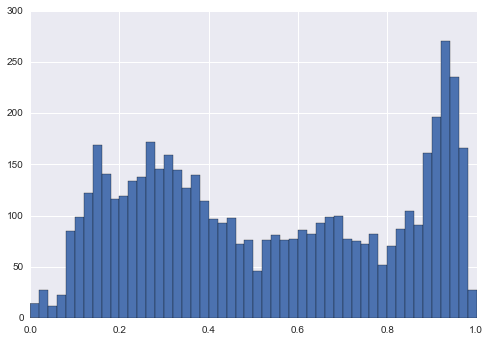

In [11]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

_ = plt.hist(submission1['pred'].values, bins = 50)

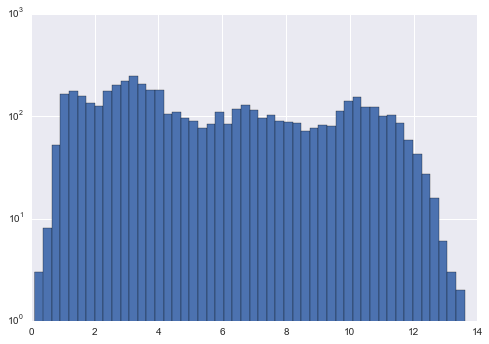

In [12]:
_ = plt.hist(np.log(1 + submission2['pred'].values), bins = 50, log = True)

In [13]:
submission1.to_csv('task1.csv', index = False)
submission2.to_csv('task2.csv', index = False)